In [1]:
import copy
import os
import torch
from torchsummary import summary
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm
import sklearn.preprocessing
#from directory_tree import display_tree
# Customed Library
import engine ,model_builder,utils
import numpy as np
#import torchinfo
from timeit import default_timer as timer 
import matplotlib.pyplot as plt
#display_tree('./')

In [2]:
Total_dataset = pd.read_pickle("./pickle/trial.pkl")  
Total_dataset

,Force_X,Force_Y,Force_Z,Torque_X,Torque_Y,Torque_Z,Input_P_1,Input_P_2,Flag,Sensor_P_1_1,...,Sensor_P_3_2,Sensor_P_4_1,Sensor_P_4_2,Sensor_P_5_1,Sensor_P_5_2,Sensor_P_6_1,Sensor_P_6_2,Sensor_S,Par1,Par2
0,0.000794,-0.205805,0.490874,-0.005637,0.000218,-0.000148,0.0,0.0,False,776.299988,...,773.700012,747.299988,777.799988,1036.500000,1045.699951,527.400024,798.799988,6694.399902,first,0
1,0.000794,-0.205805,0.490874,-0.005637,0.000218,-0.000148,0.0,0.0,False,776.299988,...,773.700012,747.299988,777.799988,1036.500000,1045.699951,527.400024,798.799988,6691.500000,first,0
2,0.000794,-0.205805,0.490874,-0.005637,0.000218,-0.000148,0.0,0.0,False,776.299988,...,773.700012,747.299988,777.799988,1036.500000,1045.699951,527.400024,798.799988,6691.500000,first,0
3,0.000794,-0.205805,0.490874,-0.005637,0.000218,-0.000148,0.0,0.0,False,776.299988,...,773.700012,747.299988,777.799988,1036.500000,1045.699951,527.400024,798.799988,6691.500000,first,0
4,0.000794,-0.205805,0.490874,-0.005637,0.000218,-0.000148,0.0,0.0,False,776.200012,...,773.700012,747.299988,777.799988,1036.500000,1045.699951,527.400024,798.799988,6691.500000,first,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20595,0.001068,-0.207219,0.503291,-0.005527,0.000286,-0.000279,0.0,0.0,False,673.200012,...,774.200012,744.799988,774.299988,1034.199951,1041.600098,523.000000,797.799988,6678.199707,first,0
20596,0.001068,-0.207219,0.503291,-0.005527,0.000286,-0.000279,0.0,0.0,False,673.200012,...,774.200012,744.799988,774.299988,1034.199951,1041.600098,523.000000,797.799988,6678.199707,first,0
20597,0.001068,-0.207219,0.503291,-0.005527,0.000286,-0.000279,0.0,0.0,False,673.200012,...,774.200012,744.799988,774.299988,1034.199951,1041.600098,523.099976,798.500000,6678.199707,first,0
20598,0.001068,-0.207219,0.503291,-0.005527,0.000286,-0.000279,0.0,0.0,False,673.200012,...,774.200012,744.799988,774.299988,1034.199951,1041.600098,523.099976,798.500000,6678.199707,first,0


<Axes: >

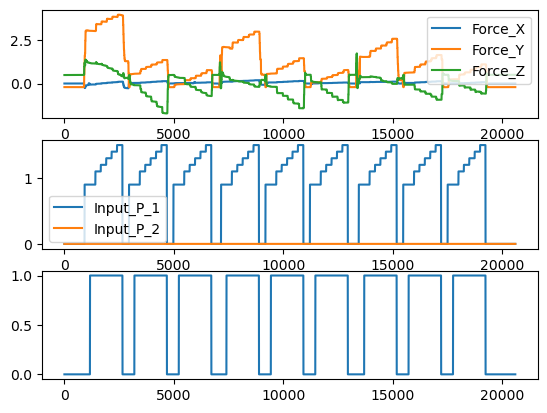

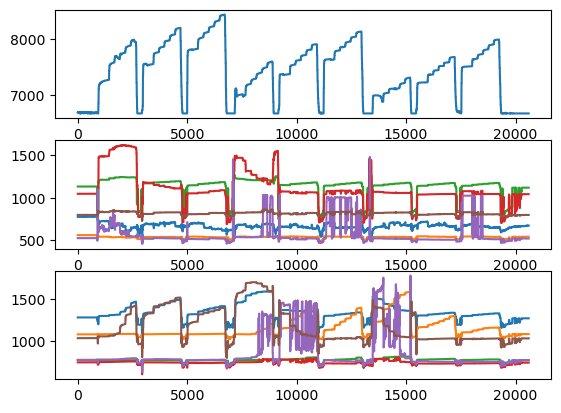

In [3]:
Fol_col=Total_dataset.columns[:3]
Input_P_col=Total_dataset.columns[6:8]
Flag_col=Total_dataset.columns[8]
#P_Sensor_col=Total_dataset.columns[9:21]
U_P_Sensor_col=['Sensor_P_1_1', 'Sensor_P_1_2',
                'Sensor_P_2_1',
                'Sensor_P_5_2',
                'Sensor_P_6_1', 'Sensor_P_6_2']

L_P_Sensor_col=['Sensor_P_2_2',
                'Sensor_P_3_1', 'Sensor_P_3_2',
                'Sensor_P_4_1', 'Sensor_P_4_2',
                'Sensor_P_5_1', ]
S_Sensor_col=Total_dataset.columns[21]


fig, axes = plt.subplots(nrows=3, ncols=1)
Total_dataset[Fol_col].plot(ax=axes[0])
Total_dataset[Input_P_col].plot(ax=axes[1])
Total_dataset[Flag_col].replace({True: 1, False: 0}).plot(ax=axes[2])
fig, axes = plt.subplots(nrows=3, ncols=1)
Total_dataset[S_Sensor_col].plot(ax=axes[0])

Total_dataset[U_P_Sensor_col].plot(ax=axes[1],legend=None)


Total_dataset[L_P_Sensor_col].plot(ax=axes[2],legend=None)




In [4]:
Filtered_dataset=Total_dataset.query('Flag==True')
Filtered_dataset

,Force_X,Force_Y,Force_Z,Torque_X,Torque_Y,Torque_Z,Input_P_1,Input_P_2,Flag,Sensor_P_1_1,...,Sensor_P_3_2,Sensor_P_4_1,Sensor_P_4_2,Sensor_P_5_1,Sensor_P_5_2,Sensor_P_6_1,Sensor_P_6_2,Sensor_S,Par1,Par2
1167,-0.063664,3.048691,1.187733,-0.172625,-0.004700,0.016825,0.9,0.0,True,727.200012,...,773.599976,751.299988,780.799988,1057.400024,1482.000000,623.099976,832.100037,7250.000000,first,0
1168,-0.063664,3.048691,1.187733,-0.172625,-0.004700,0.016825,0.9,0.0,True,727.200012,...,773.599976,751.299988,780.600037,1057.199951,1482.199951,662.099976,832.100037,7250.000000,first,0
1169,-0.063664,3.048691,1.187733,-0.172625,-0.004700,0.016825,0.9,0.0,True,727.200012,...,773.599976,751.299988,780.600037,1057.199951,1482.199951,662.099976,832.100037,7250.000000,first,0
1170,-0.063664,3.048691,1.187733,-0.172625,-0.004700,0.016825,0.9,0.0,True,727.200012,...,773.599976,751.299988,780.600037,1057.199951,1482.199951,662.099976,832.400024,7250.000000,first,0
1171,-0.063664,3.048691,1.187733,-0.172625,-0.004700,0.016825,0.9,0.0,True,727.200012,...,773.599976,751.299988,780.600037,1057.199951,1482.199951,662.099976,832.400024,7250.000000,first,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,0.077320,1.105598,-0.584631,-0.121753,0.010542,0.003864,1.5,0.0,True,649.400024,...,783.099976,738.700012,753.900024,1032.199951,1043.400024,514.400024,806.599976,7992.299805,first,0
19233,0.077320,1.105598,-0.584631,-0.121753,0.010542,0.003864,1.5,0.0,True,649.400024,...,783.099976,738.700012,753.900024,1032.199951,1043.400024,514.400024,806.599976,7991.799805,first,0
19234,0.077320,1.105598,-0.584631,-0.121753,0.010542,0.003864,1.5,0.0,True,649.400024,...,783.099976,738.700012,753.900024,1032.199951,1043.400024,514.400024,806.599976,7991.799805,first,0
19235,0.077320,1.105598,-0.584631,-0.121753,0.010542,0.003864,0.0,0.0,True,656.099976,...,783.099976,738.700012,753.900024,1032.199951,1043.400024,514.400024,806.599976,7991.799805,first,0


<Axes: >

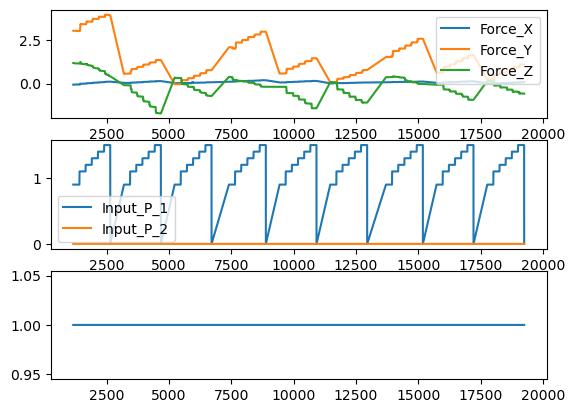

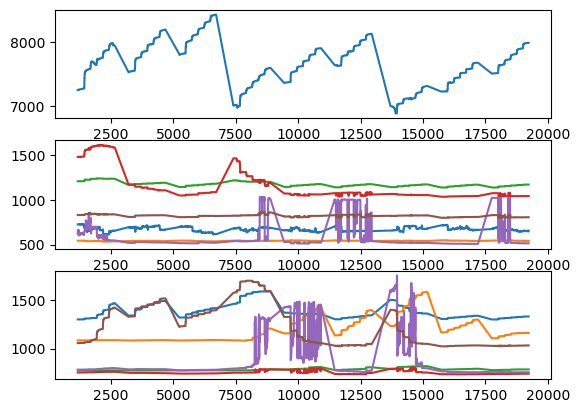

In [5]:
Fol_col=Filtered_dataset.columns[:3]
Input_P_col=Filtered_dataset.columns[6:8]
Flag_col=Filtered_dataset.columns[8]
#P_Sensor_col=Total_dataset.columns[9:21]
U_P_Sensor_col=['Sensor_P_1_1', 'Sensor_P_1_2',
                'Sensor_P_2_1',
                'Sensor_P_5_2',
                'Sensor_P_6_1', 'Sensor_P_6_2']

L_P_Sensor_col=['Sensor_P_2_2',
                'Sensor_P_3_1', 'Sensor_P_3_2',
                'Sensor_P_4_1', 'Sensor_P_4_2',
                'Sensor_P_5_1', ]
S_Sensor_col=Filtered_dataset.columns[21]


fig, axes = plt.subplots(nrows=3, ncols=1)
Filtered_dataset[Fol_col].plot(ax=axes[0])
Filtered_dataset[Input_P_col].plot(ax=axes[1])
Filtered_dataset[Flag_col].replace({True: 1, False: 0}).plot(ax=axes[2])
fig, axes = plt.subplots(nrows=3, ncols=1)
Filtered_dataset[S_Sensor_col].plot(ax=axes[0])

Filtered_dataset[U_P_Sensor_col].plot(ax=axes[1],legend=None)


Filtered_dataset[L_P_Sensor_col].plot(ax=axes[2],legend=None)


## Learning procss

In [12]:
Combi_df =Filtered_dataset 


# Setup hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
#!nvidia-smi

# Hot encoding needed
# Scailing!
# Validation dataset?

Y=np.array(Combi_df.filter(items=Filtered_dataset.columns[:3]))
X=np.array(Combi_df.filter(items=Filtered_dataset.columns[6:22]))

# Scaler
X_scaler = sklearn.preprocessing.MinMaxScaler()
Y_scaler = sklearn.preprocessing.MinMaxScaler()

X=torch.FloatTensor(X_scaler.fit_transform(X))
Y=torch.FloatTensor(Y_scaler.fit_transform(Y))



X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size=0.2 # 20% test, 80% train
                                                    #,shuffle=False#,random_state=42
                                                   ) # make the random split reproducible


train_dataset=DataLoader(utils.Data(X_train,Y_train),batch_size=BATCH_SIZE)
test_dataset=DataLoader(utils.Data(X_test,Y_test),batch_size=BATCH_SIZE)
Input_dim=len(X_train[0])
Output_dim=len(Y_train[0])





train_features, train_labels = next(iter(train_dataset))
print(f'{"Input feature: ":>20}{Input_dim}{"||":^22}{"Output feature: ":>20}{Output_dim}')
print(f'Input Train: {len(X_train)},Test: {len(X_test)}     ||   Output Train: {len(Y_train)}, Test: {len(Y_test)}')

print(f"Input  :: [batch] X [Sequnetial] X [feature] -----> {train_features.size()}")
print(f"Output :: [batch]                X [feature] -----> {train_labels.size()}")

     Input feature: 16          ||              Output feature: 3
Input Train: 10685,Test: 2672     ||   Output Train: 10685, Test: 2672
Input  :: [batch] X [Sequnetial] X [feature] -----> torch.Size([32, 1, 16])
Output :: [batch]                X [feature] -----> torch.Size([32, 3])


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1043 | test_loss: 0.0496 | 
Epoch: 2 | train_loss: 0.0512 | test_loss: 0.0480 | 
Epoch: 3 | train_loss: 0.0475 | test_loss: 0.0451 | 
Epoch: 4 | train_loss: 0.0452 | test_loss: 0.0427 | 
Epoch: 5 | train_loss: 0.0436 | test_loss: 0.0407 | 
Total training time: 9.220 seconds


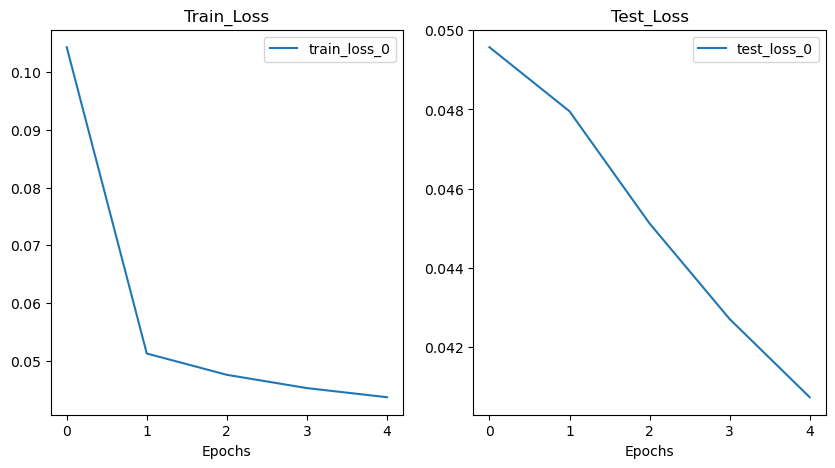

In [42]:
# Model

model = model_builder.LSTMModel(
    input_dim = Input_dim,
    hidden_dim=HIDDEN_UNITS,
    layer_dim=2,
    output_dim=Output_dim,
    dropout_prob=0.7)
# Set loss and optimizer
loss_fn = torch.nn.MSELoss() ## change
optimizer = torch.optim.Adam(model.parameters(), ## change
                             lr=LEARNING_RATE)
# Train
#torchinfo.summary(model,(5,5,5))
start_time = timer()
results=engine.train(model=model,
             train_dataloader=train_dataset,
             test_dataloader=test_dataset,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
utils.plot_loss_curves([results])

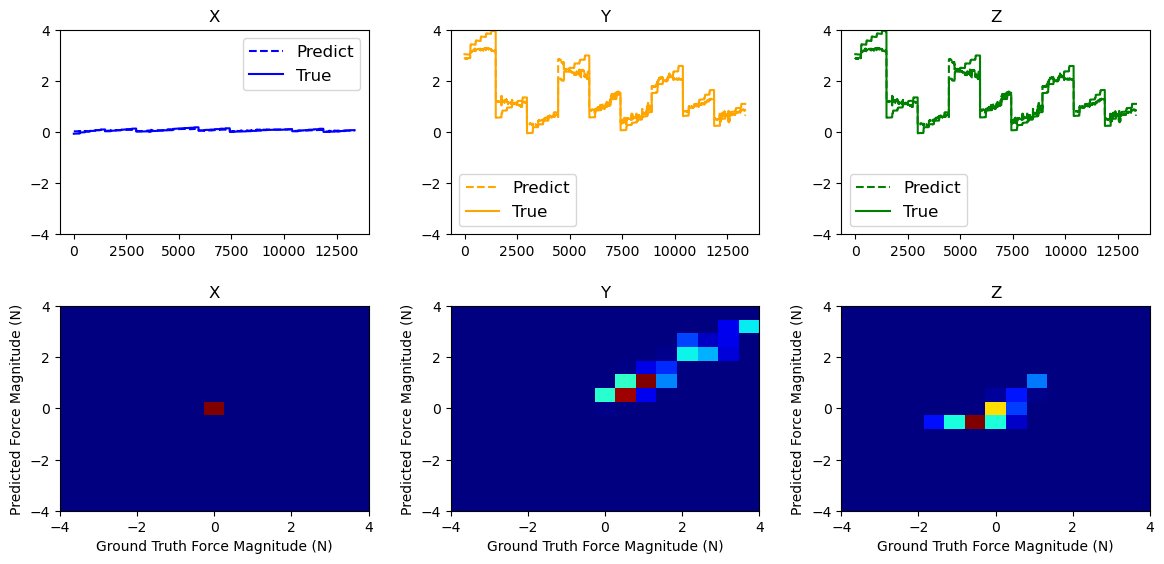

In [14]:
Pred_Values=Y_scaler.inverse_transform(utils.predict(model,DataLoader(utils.Data(X,Y),batch_size=BATCH_SIZE)))
True_Values=Y_scaler.inverse_transform(Y)
utils.plot_prediction(Pred_Values,True_Values)

## Different Input feature combination
1. Only input pressure
2. Input pressure + TCP
3. Only Pressure
4. Only Strain
5. Pressure sensor + input pressure
6. Strain sensor + Input pressure
7. Pressure + Strain
8. Pressure + Strain + Input pressure
9. Pressure + Strain + Input Pressure + TCP
10. Pressure + Strain + Input Pressure + Object knowledge
11. Pressure(1/2) + Strain + Input Pressure


In [33]:
con1=Filtered_dataset.columns[6:8] # input pressure
#con2=Filtered_dataset.columns[6:8]
con3=Filtered_dataset.columns[9:21] # Only pressure sensor
con4=Filtered_dataset.columns[21] # only Strain Sensor
con5=Filtered_dataset.columns[9:22] # all Sensor
con6=Filtered_dataset.columns[6:22] # all Sensor + Given pressure
con7=Filtered_dataset.columns[6:21] # input pressure + pressure
con8=Filtered_dataset.columns[6:8].append(pd.Index([Filtered_dataset.columns[21]])) # input pressure + Strain sensor




In [54]:
con1

Index(['Input_P_1', 'Input_P_2'], dtype='object')

Input combination is Index(['Input_P_1', 'Input_P_2'], dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1365 | test_loss: 0.0491 | 
Epoch: 2 | train_loss: 0.0541 | test_loss: 0.0490 | 
Epoch: 3 | train_loss: 0.0514 | test_loss: 0.0490 | 
Epoch: 4 | train_loss: 0.0509 | test_loss: 0.0490 | 
Epoch: 5 | train_loss: 0.0507 | test_loss: 0.0489 | 


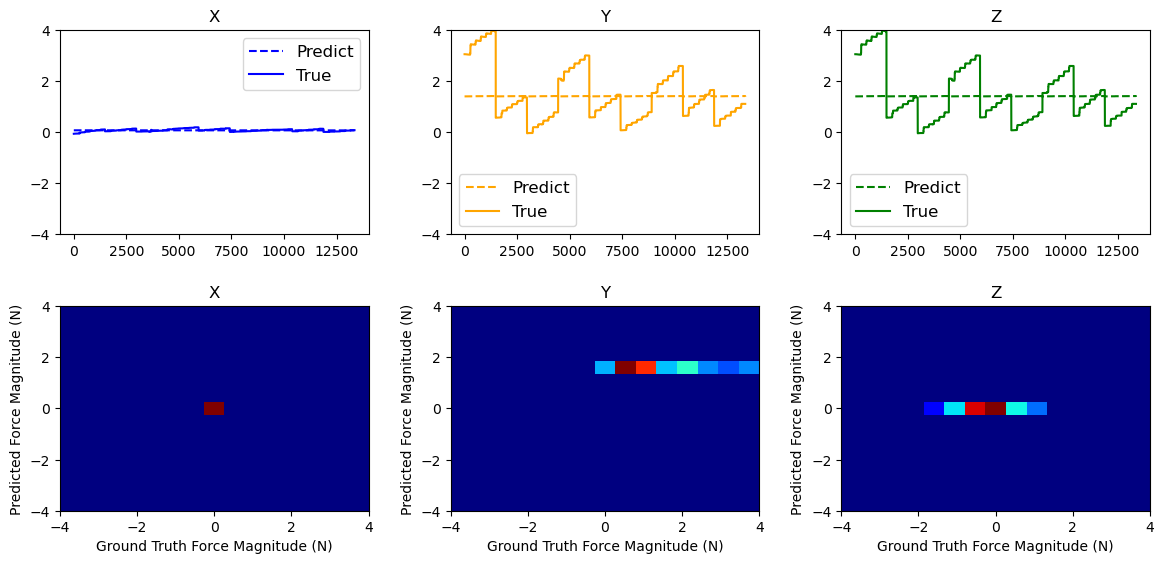

Input combination is Index(['Sensor_P_1_1', 'Sensor_P_1_2', 'Sensor_P_2_1', 'Sensor_P_2_2',
       'Sensor_P_3_1', 'Sensor_P_3_2', 'Sensor_P_4_1', 'Sensor_P_4_2',
       'Sensor_P_5_1', 'Sensor_P_5_2', 'Sensor_P_6_1', 'Sensor_P_6_2'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1225 | test_loss: 0.0440 | 
Epoch: 2 | train_loss: 0.0456 | test_loss: 0.0361 | 
Epoch: 3 | train_loss: 0.0360 | test_loss: 0.0281 | 
Epoch: 4 | train_loss: 0.0292 | test_loss: 0.0218 | 
Epoch: 5 | train_loss: 0.0248 | test_loss: 0.0161 | 


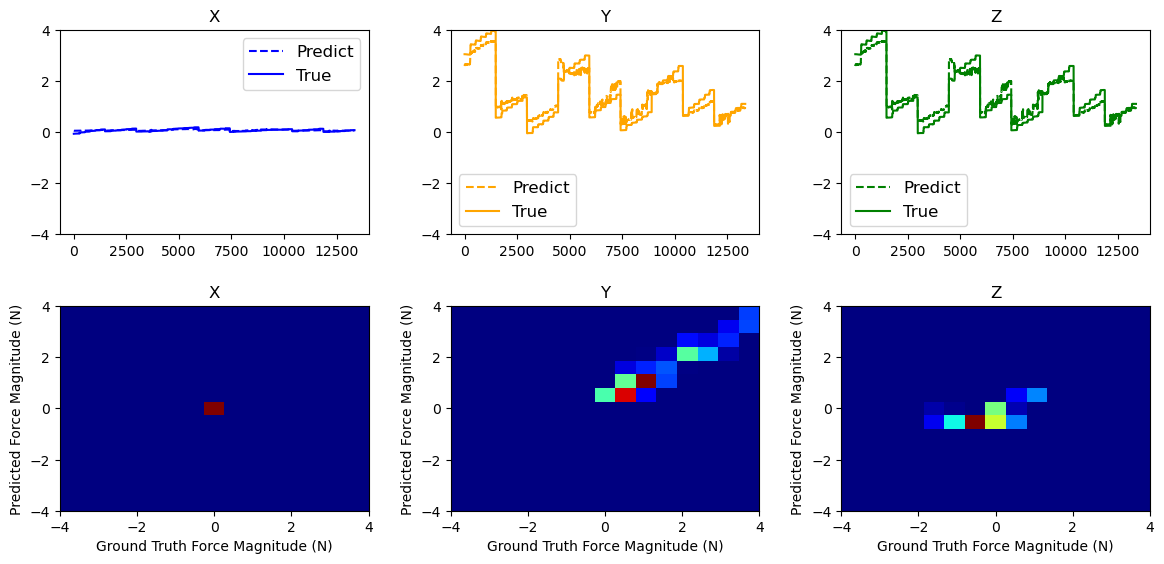

Input combination is Index(['Sensor_P_1_1', 'Sensor_P_1_2', 'Sensor_P_2_1', 'Sensor_P_2_2',
       'Sensor_P_3_1', 'Sensor_P_3_2', 'Sensor_P_4_1', 'Sensor_P_4_2',
       'Sensor_P_5_1', 'Sensor_P_5_2', 'Sensor_P_6_1', 'Sensor_P_6_2',
       'Sensor_S'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0889 | test_loss: 0.0332 | 
Epoch: 2 | train_loss: 0.0328 | test_loss: 0.0196 | 
Epoch: 3 | train_loss: 0.0248 | test_loss: 0.0141 | 
Epoch: 4 | train_loss: 0.0221 | test_loss: 0.0121 | 
Epoch: 5 | train_loss: 0.0205 | test_loss: 0.0108 | 


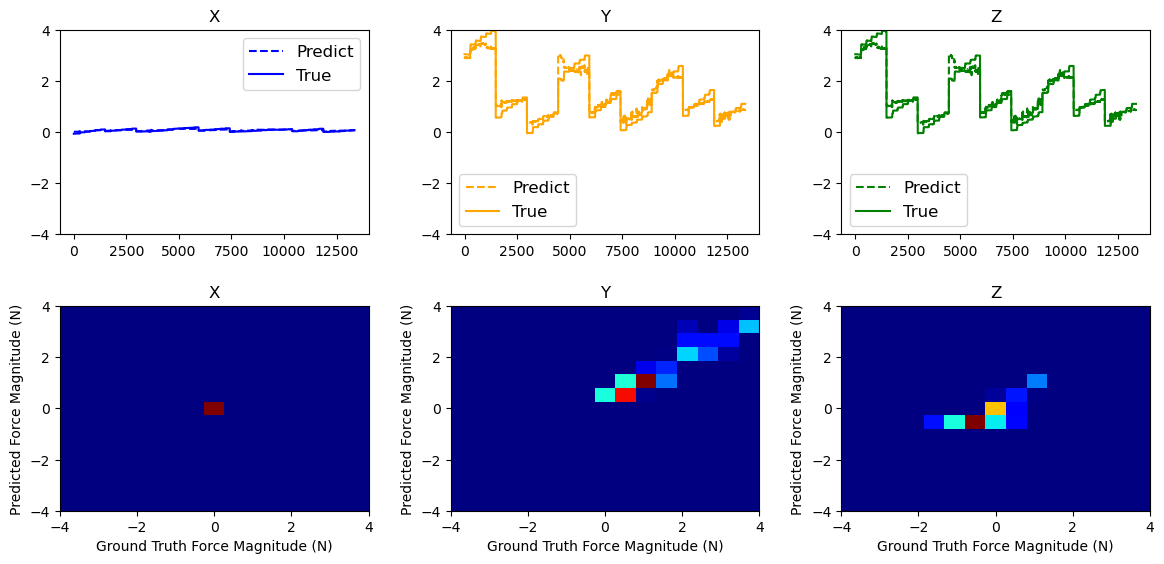

Input combination is Index(['Input_P_1', 'Input_P_2', 'Flag', 'Sensor_P_1_1', 'Sensor_P_1_2',
       'Sensor_P_2_1', 'Sensor_P_2_2', 'Sensor_P_3_1', 'Sensor_P_3_2',
       'Sensor_P_4_1', 'Sensor_P_4_2', 'Sensor_P_5_1', 'Sensor_P_5_2',
       'Sensor_P_6_1', 'Sensor_P_6_2', 'Sensor_S'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1216 | test_loss: 0.0348 | 
Epoch: 2 | train_loss: 0.0361 | test_loss: 0.0236 | 
Epoch: 3 | train_loss: 0.0288 | test_loss: 0.0217 | 
Epoch: 4 | train_loss: 0.0261 | test_loss: 0.0173 | 
Epoch: 5 | train_loss: 0.0225 | test_loss: 0.0123 | 


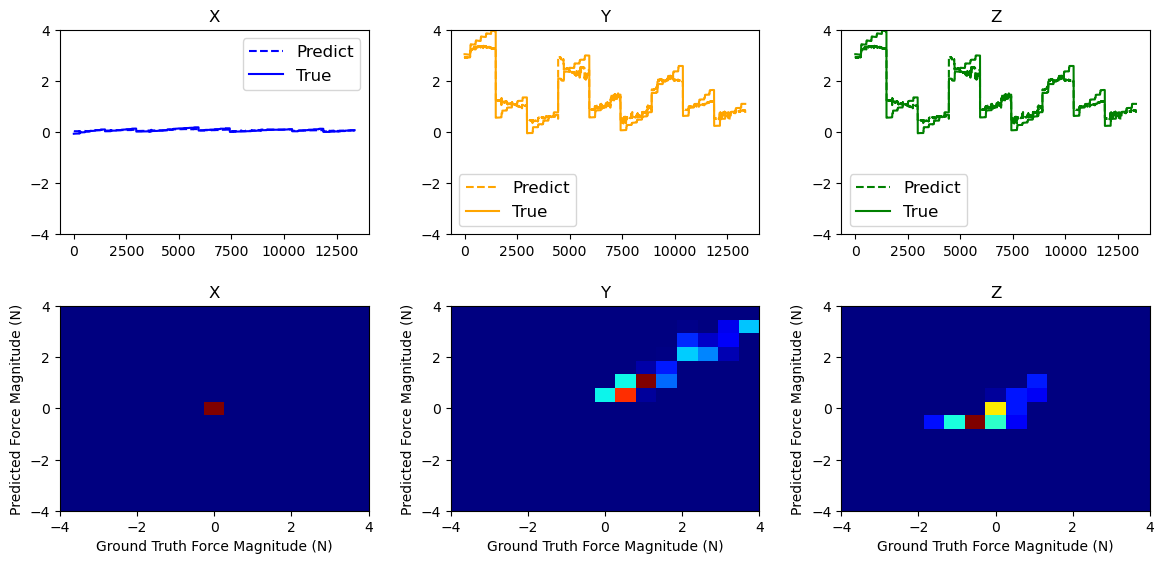

Input combination is Index(['Input_P_1', 'Input_P_2', 'Flag', 'Sensor_P_1_1', 'Sensor_P_1_2',
       'Sensor_P_2_1', 'Sensor_P_2_2', 'Sensor_P_3_1', 'Sensor_P_3_2',
       'Sensor_P_4_1', 'Sensor_P_4_2', 'Sensor_P_5_1', 'Sensor_P_5_2',
       'Sensor_P_6_1', 'Sensor_P_6_2'],
      dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0599 | test_loss: 0.0366 | 
Epoch: 2 | train_loss: 0.0302 | test_loss: 0.0188 | 
Epoch: 3 | train_loss: 0.0241 | test_loss: 0.0145 | 
Epoch: 4 | train_loss: 0.0214 | test_loss: 0.0128 | 
Epoch: 5 | train_loss: 0.0196 | test_loss: 0.0111 | 


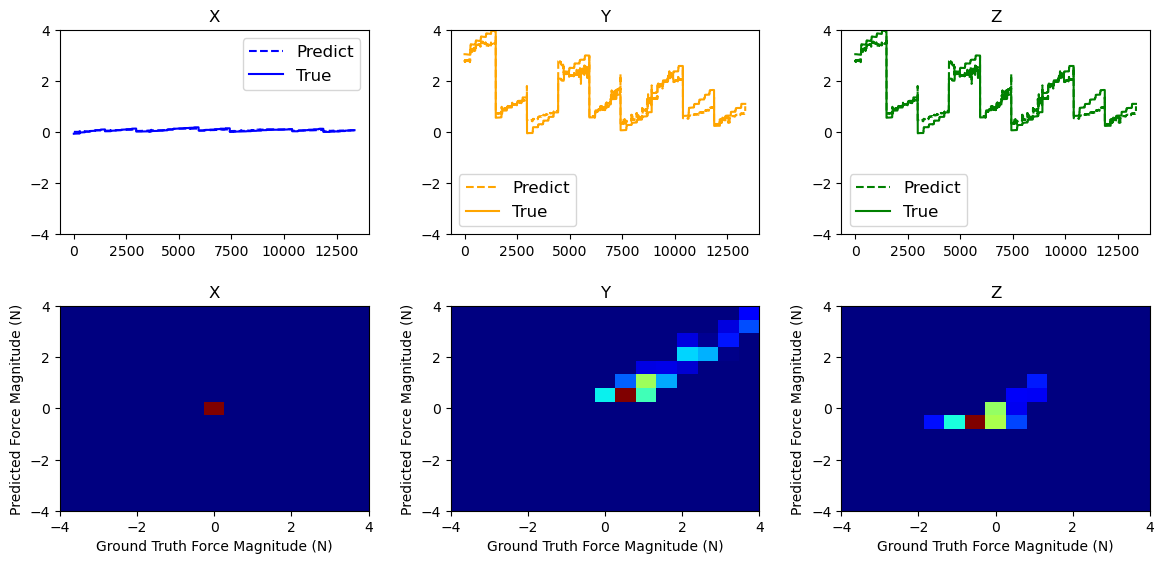

Input combination is Index(['Input_P_1', 'Input_P_2', 'Sensor_S'], dtype='object')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0963 | test_loss: 0.0500 | 
Epoch: 2 | train_loss: 0.0520 | test_loss: 0.0493 | 
Epoch: 3 | train_loss: 0.0498 | test_loss: 0.0484 | 
Epoch: 4 | train_loss: 0.0480 | test_loss: 0.0457 | 
Epoch: 5 | train_loss: 0.0459 | test_loss: 0.0429 | 


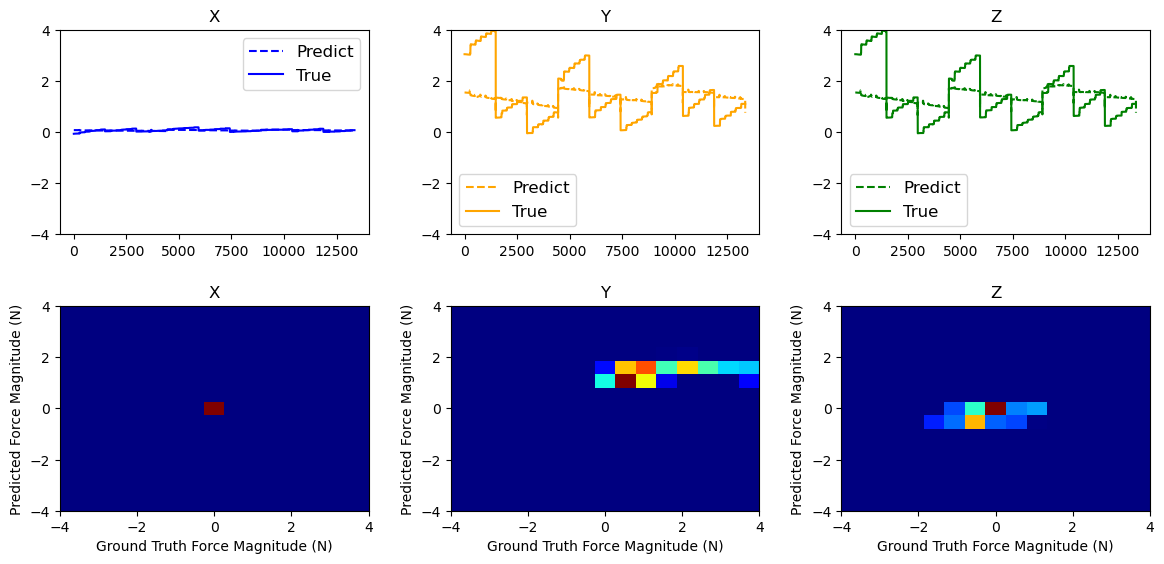

In [53]:
Compare_input_feature=[con1, con3,con5,con6,con7,con8]
duration_time=[]
loss_results=[]

for i in range(len(Compare_input_feature)):
    ### Data Prepare
    print(f'Input combination is {Compare_input_feature[i]}')
    Y=np.array(Combi_df.filter(items=Filtered_dataset.columns[:3]))
    X=np.array(Combi_df.filter(items=Compare_input_feature[i])) ## important part

    
    X_scaler = sklearn.preprocessing.MinMaxScaler()
    Y_scaler = sklearn.preprocessing.MinMaxScaler()

    X=torch.FloatTensor(X_scaler.fit_transform(X))
    Y=torch.FloatTensor(Y_scaler.fit_transform(Y))



    X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                        Y, 
                                                        test_size=0.2 # 20% test, 80% train
                                                        #,shuffle=False#,random_state=42
                                                       ) # make the random split reproducible
    train_dataset=DataLoader(utils.Data(X_train,Y_train),batch_size=BATCH_SIZE)
    test_dataset=DataLoader(utils.Data(X_test,Y_test),batch_size=BATCH_SIZE)
    Input_dim=len(X_train[0])
    Output_dim=len(Y_train[0])
    
    
    ## Build
    model = model_builder.LSTMModel(
    input_dim = Input_dim,
    hidden_dim=HIDDEN_UNITS,
    layer_dim=2,
    output_dim=Output_dim,
    dropout_prob=0.7)
    # Set loss and optimizer
    loss_fn = torch.nn.MSELoss() ## change
    optimizer = torch.optim.Adam(model.parameters(), ## change
                                 lr=LEARNING_RATE)
    # Train
    #torchinfo.summary(model,(5,5,5))
    start_time = timer()
    results=engine.train(model=model,
                 train_dataloader=train_dataset,
                 test_dataloader=test_dataset,
                 loss_fn=loss_fn,
                 optimizer=optimizer,
                 epochs=NUM_EPOCHS,
                 device=device)
    end_time = timer()
    
    duration_time.append(end_time-start_time)
    loss_results.append(results)
    Pred_Values=Y_scaler.inverse_transform(utils.predict(model,DataLoader(utils.Data(X,Y),batch_size=BATCH_SIZE)))
    True_Values=Y_scaler.inverse_transform(Y)
    utils.plot_prediction(Pred_Values,True_Values)
    '''utils.save_model(model=model,
                     target_dir="models",
                     model_name="combination"+str(i)+".pth")'''
    

Text(0, 0.5, 'Time taken [s]')

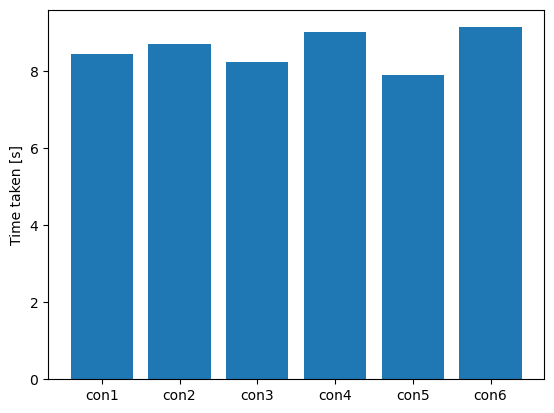

In [49]:
xx=['con1','con2','con3','con4','con5','con6']
plt.bar(xx,duration_time)
plt.ylabel('Time taken [s]')

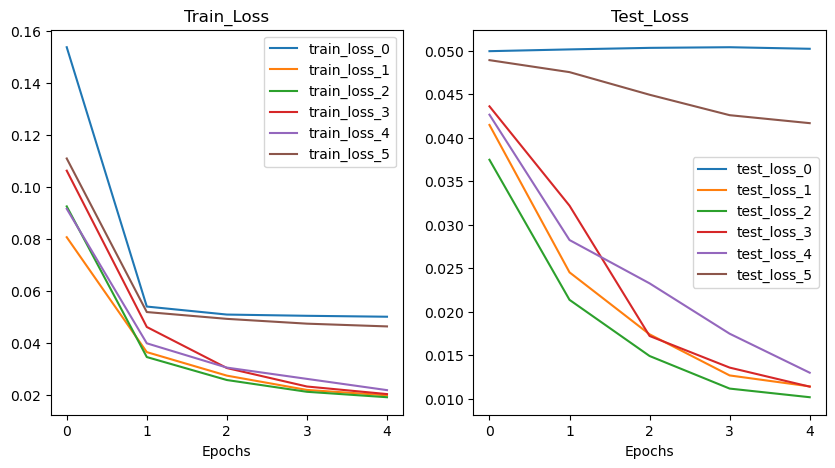

In [51]:
utils.plot_loss_curves(loss_results)

In [ ]:
for i in range(len(Compare_input_feature)):
    model_name="combination"+str(i)+".pth"
    model = torch.load(PATH)
    model.eval()
    Pred_Values=Y_scaler.inverse_transform(utils.predict(model,DataLoader(utils.Data(X,Y),batch_size=BATCH_SIZE)))
    True_Values=Y_scaler.inverse_transform(Y)
    utils.plot_prediction(Pred_Values,True_Values)

## Save Model

In [ ]:
'''
utils.save_model(model=model,
                 target_dir="models",
                 model_name="1st_trial.pth")
                 '''
model = torch.load(PATH)
model.eval()
